In [177]:
import sys
sys.path.append('D:/Ayush/ScienceFair11thGrade/free-support-barycenters')
from bary import *

In [178]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score


data = pd.read_csv(
    'heart_data.csv'
)

In [179]:
data.loc[data.INCOME3 < 4, "Income"] = "Very Low"
data.loc[(data.INCOME3 < 7) & (data.INCOME3 >= 4), "Income"] = "Low"
data.loc[(data.INCOME3 < 9) & (data.INCOME3 >= 7), "Income"] = "Medium"
data.loc[(data.INCOME3 < 77) & (data.INCOME3 >= 9), "Income"] = "High"

In [180]:
data = data.groupby(['Income'], group_keys=False).apply(lambda x: x.sample(frac=0.05, random_state=2023))

In [181]:
from imblearn.under_sampling import RandomUnderSampler
cvd_distribution = data['CVDCRHD4'].value_counts()
undersample = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X= data.drop('CVDCRHD4', axis=1)
y = data['CVDCRHD4']
X_resampled, y_resampled = undersample.fit_resample(X, y)
data = pd.concat([pd.DataFrame(X_resampled, columns = X.columns), pd.DataFrame(y_resampled, columns=['CVDCRHD4'])], axis=1)

In [182]:
data.sample(n=7).head()

,Unnamed: 0,SEXVAR,INCOME3,_RFHLTH,_RFDRHV8,_AGE80,SMOKE100,_METSTAT,_PRACE2,MENTHLTH,Income,CVDCRHD4
257564,318245,2.0,8.0,1.0,1.0,74.0,1.0,1.0,1.0,88.0,Medium,1.0
327415,404604,1.0,3.0,1.0,1.0,67.0,1.0,1.0,1.0,88.0,Very Low,0.0
216296,267866,2.0,6.0,1.0,1.0,40.0,2.0,1.0,2.0,88.0,Low,1.0
256790,317310,1.0,8.0,1.0,1.0,18.0,2.0,1.0,1.0,20.0,Medium,1.0
106448,133541,1.0,4.0,1.0,1.0,73.0,1.0,1.0,88.0,88.0,Low,0.0


In [183]:
import pickle
import ot

seed_list = [2023, 2024, 2025, 2026, 2027]
randommap = 1  # 1: Random; 0: Average
sigma = 0.1
NUM_LABELS = 2
train_proba_temp_list = []
test_proba_temp_list = []
supports_list = []
supports_test_list = []
masses_list = []
masses_test_list = []
for seed in seed_list:
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=seed)
    train_data = train_data.sort_values(by="Income")
    train_data.reset_index(drop=True, inplace=True)
    groupsize = train_data.groupby("Income").size()

    test_data = test_data.sort_values(by="Income")
    test_data.reset_index(drop=True, inplace=True)
    groupsize_test = test_data.groupby("Income").size()

    X_train = train_data.copy()
    X_test = test_data.copy()
    y_train = train_data["CVDCRHD4"].copy()
    y_test = test_data["CVDCRHD4"].copy()
    del X_train["Income"]
    del X_test["Income"]
    del X_train["CVDCRHD4"]
    del X_test["CVDCRHD4"]

    X = pd.concat([X_train, X_test])
    X = pd.get_dummies(X)

    X_train = X[0 : train_data.shape[0]].copy()
    X_test = X[train_data.shape[0] :].copy()

    scaler = MinMaxScaler()

    X_train = pd.DataFrame(
        scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index
    )
    X_test = pd.DataFrame(
        scaler.transform(X_test), columns=X_test.columns, index=X_test.index
    )

    logreg = LogisticRegression(max_iter=10000)
    logreg.fit(X_train, y_train)
    print(accuracy_score(y_test, logreg.predict(X_test)))
    print(logreg.predict(X_test))

    import numpy as np

    supports = logreg.predict_proba(X_train)
    supports_test = logreg.predict_proba(X_test)
    masses = [None] * len(groupsize)
    masses_test = [None] * len(groupsize)
    tempsize = np.insert(np.cumsum(groupsize.to_numpy()), 0, 0)
    tempsize_test = np.insert(np.cumsum(groupsize_test.to_numpy()), 0, 0)
    for i in range(len(groupsize)):
        temp = np.zeros(np.sum(groupsize))
        temp[tempsize[i] : tempsize[i + 1]] = 1.0 / groupsize[i]
        masses[i] = temp
        temp = np.zeros(np.sum(groupsize_test))
        temp[tempsize_test[i] : tempsize_test[i + 1]] = 1.0 / groupsize_test[i]
        masses_test[i] = temp
    supports_list.append(supports)
    supports_test_list.append(supports_test)
    masses_list.append(masses)
    masses_test_list.append(masses_test)

    # Compute Barycenter
    pairwise_supp, pairwise_masses, err_bound = pairwise_bary(
        supports, masses, compute_err_bound=True
    )

    T = [None] * len(groupsize)
    for i in range(len(groupsize)):
        print(i)
        M = ot.dist(supports[train_data.Income == groupsize.index[i]], pairwise_supp)
        a = [1 / groupsize[i]] * groupsize[i]
        b = pairwise_masses
        T[i] = ot.emd(a, b, M, numItermax=200000)

    train_proba_temp = [None] * len(groupsize)
    test_proba_temp = [None] * len(groupsize)
    np.random.seed(seed)
    for i in range(len(groupsize)):
        print([i, seed])
        train_proba_temp[i] = np.empty((groupsize[i], NUM_LABELS))
        test_proba_temp[i] = np.empty((groupsize_test[i], NUM_LABELS))
        for j in range(T[i].shape[0]):
            if randommap == 1:
                index = np.random.choice(
                    np.nonzero(T[i][j])[0],
                    1,
                    p=T[i][j][np.nonzero(T[i][j])[0]] * T[i].shape[0],
                )
                train_proba_temp[i][j] = pairwise_supp[index]
            else:
                train_proba_temp[i][j] = np.matmul(
                    T[i][j] * T[i].shape[0], pairwise_supp
                )
        M_test_to_train = ot.dist(
            supports_test[tempsize_test[i] : tempsize_test[i + 1], :],
            supports[tempsize[i] : tempsize[i + 1], :],
        )
        kernel_density_test = (
            np.exp(-M_test_to_train / (2 * sigma * sigma)) / sigma / np.sqrt(2 * np.pi)
        )
        kernel_density_test_sum = np.sum(kernel_density_test, 1)
        T_test = (
            np.matmul(kernel_density_test, T[i])
            / kernel_density_test_sum[:, None]
            * groupsize[i]
        )
        for j in range(groupsize_test[i]):
            if randommap == 1:
                index = np.random.choice(range(supports.shape[0]), 1, p=T_test[j, :])
                test_proba_temp[i][j] = pairwise_supp[index]
            else:
                test_proba_temp[i][j] = np.matmul(T_test[j, :], pairwise_supp)
    train_proba_temp_list.append(train_proba_temp)
    test_proba_temp_list.append(test_proba_temp)


0.71900826446281
[1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1.
 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1.
 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 

In [184]:
groupsize

Income
High        337
Low         494
Medium      456
Very Low    164
dtype: int64

In [185]:
data.Income.value_counts()

Low         614
Medium      565
High        431
Very Low    204
Name: Income, dtype: int64

In [186]:
import pickle

try:
    print("1")
    train_proba_temp_list = pickle.load(
        open(
            r"heart/income/train_proba_temp_list.pkl",
            "rb",
        )
    )
    test_proba_temp_list = pickle.load(
        open(
            r"heart/income/test_proba_temp_list.pkl",
            "rb",
        )
    )
    supports_list = pickle.load(
        open(
            r"heart/income/supports_list.pkl",
            "rb",
        )
    )
    supports_test_list = pickle.load(
        open(
            r"heart/income/supports_test_list.pkl",
            "rb",
        )
    )
    masses_list = pickle.load(
        open(
            r"heart/income/masses_list.pkl",
            "rb",
        )
    )
    masses_test_list = pickle.load(
        open(
            r"heart/income/masses_test_list.pkl",
            "rb",
        )
    )

except FileNotFoundError as e:

    pickle.dump(
        train_proba_temp_list,
        open(
            r"heart/income/train_proba_temp_list.pkl",
            "wb",
        ),
    )
    pickle.dump(
        test_proba_temp_list,
        open(
            r"heart/income/test_proba_temp_list.pkl",
            "wb",
        ),
    )
    pickle.dump(
        supports_list,
        open(
            r"heart/income/supports_list.pkl",
            "wb",
        ),
    )
    pickle.dump(
        supports_test_list,
        open(
            r"heart/income/supports_test_list.pkl",
            "wb",
        ),
    )
    pickle.dump(
        masses_list,
        open(
            r"heart/income/masses_list.pkl",
            "wb",
        ),
    )
    pickle.dump(
        masses_test_list,
        open(
            r"heart/income/masses_test_list.pkl",
            "wb",
        ),
    )


1


In [187]:
# Evaluation performance part 1 for all seed in a loop
from sklearn.metrics import accuracy_score, roc_auc_score

accuracy_list_seed = []
unfairness_list_seed = []
auc_list_seed = []
accuracy_list_test_seed = []
unfairness_list_test_seed = []
auc_list_test_seed = []
alpha_list = np.linspace(0, 1, 6)

for seed in range(len(train_proba_temp_list)):
    train_data, test_data = train_test_split(
        data, test_size=0.2, random_state=seed_list[seed]
    )
    train_data = train_data.sort_values(by="Income")
    train_data.reset_index(drop=True, inplace=True)
    groupsize = train_data.groupby("Income").size()
    test_data = test_data.sort_values(by="Income")
    test_data.reset_index(drop=True, inplace=True)
    groupsize_test = test_data.groupby("Income").size()
    tempsize = np.insert(np.cumsum(groupsize.to_numpy()), 0, 0)
    tempsize_test = np.insert(np.cumsum(groupsize_test.to_numpy()), 0, 0)

    y_train = train_data["CVDCRHD4"].copy()
    y_test = test_data["CVDCRHD4"].copy()

    train_proba_temp = train_proba_temp_list[seed]
    test_proba_temp = test_proba_temp_list[seed]
    supports = supports_list[seed]
    supports_test = supports_test_list[seed]
    masses = masses_list[seed]
    masses_test = masses_test_list[seed]
    accuracy_list = np.zeros((len(alpha_list), 1))
    unfairness_list = np.zeros((len(alpha_list), supports.shape[1]))
    auc_list = np.zeros((len(alpha_list), supports.shape[1]))
    accuracy_list_test = np.zeros((len(alpha_list), 1))
    unfairness_list_test = np.zeros((len(alpha_list), supports.shape[1]))
    auc_list_test = np.zeros((len(alpha_list), supports.shape[1]))
    train_proba_new = supports * 0
    test_proba_new = supports_test * 0
    index = 0
    for alpha in alpha_list:
        print([alpha, seed_list[seed]])
        for i in range(len(groupsize)):
            train_proba_new[tempsize[i] : tempsize[i + 1]] = (1 - alpha) * (
                train_proba_temp[i]
            ) + alpha * (supports[tempsize[i] : tempsize[i + 1]])
            test_proba_new[tempsize_test[i] : tempsize_test[i + 1]] = (1 - alpha) * (
                test_proba_temp[i]
            ) + alpha * (supports_test[tempsize_test[i] : tempsize_test[i + 1]])
            y_train_pred = np.array(
                [[0, 1][s] for s in np.argmax(train_proba_new, axis=1)]
            )
            y_test_pred = np.array(
                [[0, 1][s] for s in np.argmax(test_proba_new, axis=1)]
            )
        accuracy_list[index, 0] = accuracy_score(y_train, y_train_pred)
        accuracy_list_test[index, 0] = accuracy_score(y_test, y_test_pred)
        for i in range(supports.shape[1]):
            auc_list[index, i] = roc_auc_score(
                np.where(y_train == [0, 1][i], 1, 0),
                train_proba_new[:, i],
            )
            auc_list_test[index, i] = roc_auc_score(
                np.where(y_test == [0, 1][i], 1, 0), test_proba_new[:, i]
            )
            temp = np.zeros(len(groupsize))
            for j in range(len(groupsize)):
                temp[j] = (
                    np.sum(
                        np.where(
                            y_train_pred[tempsize[j] : tempsize[j + 1]]
                            == [0, 1][i],
                            1,
                            0,
                        )
                    )
                    / groupsize[j]
                )
            unfairness_list[index, i] = np.max(temp) - np.min(temp)
            temp = np.zeros(len(groupsize))
            for j in range(len(groupsize)):
                temp[j] = (
                    np.sum(
                        np.where(
                            y_test_pred[tempsize_test[j] : tempsize_test[j + 1]]
                            == [0, 1][i],
                            1,
                            0,
                        )
                    )
                    / groupsize_test[j]
                )
            unfairness_list_test[index, i] = np.max(temp) - np.min(temp)
        index = index + 1
    accuracy_list_seed.append(accuracy_list)
    unfairness_list_seed.append(unfairness_list)
    auc_list_seed.append(auc_list)
    accuracy_list_test_seed.append(accuracy_list_test)
    unfairness_list_test_seed.append(unfairness_list_test)
    auc_list_test_seed.append(auc_list_test)


[0.0, 2023]
[0.2, 2023]
[0.4, 2023]
[0.6000000000000001, 2023]
[0.8, 2023]
[1.0, 2023]
[0.0, 2024]
[0.2, 2024]
[0.4, 2024]
[0.6000000000000001, 2024]
[0.8, 2024]
[1.0, 2024]
[0.0, 2025]
[0.2, 2025]
[0.4, 2025]
[0.6000000000000001, 2025]
[0.8, 2025]
[1.0, 2025]
[0.0, 2026]
[0.2, 2026]
[0.4, 2026]
[0.6000000000000001, 2026]
[0.8, 2026]
[1.0, 2026]
[0.0, 2027]
[0.2, 2027]
[0.4, 2027]
[0.6000000000000001, 2027]
[0.8, 2027]
[1.0, 2027]


In [188]:
# Evaluation performance part 2 for all seed in a loop
alpha_list = np.linspace(0, 1, 6)
wasserstein_list_seed = []
wasserstein_list_test_seed = []
for seed in range(len(train_proba_temp_list)):
    train_data, test_data = train_test_split(
        data, test_size=0.2, random_state=seed_list[seed]
    )
    train_data = train_data.sort_values(by="Income")
    train_data.reset_index(drop=True, inplace=True)
    groupsize = train_data.groupby("Income").size()
    test_data = test_data.sort_values(by="Income")
    test_data.reset_index(drop=True, inplace=True)
    groupsize_test = test_data.groupby("Income").size()
    tempsize = np.insert(np.cumsum(groupsize.to_numpy()), 0, 0)
    tempsize_test = np.insert(np.cumsum(groupsize_test.to_numpy()), 0, 0)

    train_proba_temp = train_proba_temp_list[seed]
    test_proba_temp = test_proba_temp_list[seed]
    supports = supports_list[seed]
    supports_test = supports_test_list[seed]
    masses = masses_list[seed]
    masses_test = masses_test_list[seed]

    wasserstein_list = np.zeros((len(alpha_list), len(groupsize)))
    wasserstein_list_test = np.zeros((len(alpha_list), len(groupsize)))
    train_proba_new = supports * 0
    test_proba_new = supports_test * 0
    index = 0
    for alpha in alpha_list:
        for i in range(len(groupsize)):
            train_proba_new[tempsize[i] : tempsize[i + 1]] = (1 - alpha) * (
                train_proba_temp[i]
            ) + alpha * (supports[tempsize[i] : tempsize[i + 1]])
            test_proba_new[tempsize_test[i] : tempsize_test[i + 1]] = (1 - alpha) * (
                test_proba_temp[i]
            ) + alpha * (supports_test[tempsize_test[i] : tempsize_test[i + 1]])
        # pairwise_supp_temp, pairwise_masses_temp, err_bound = pairwise_bary(train_proba_new, masses, compute_err_bound=True)
        pairwise_supp_temp, pairwise_masses_temp = ref_bary(train_proba_new, masses)
        temp = np.zeros(len(groupsize))
        for i in range(len(groupsize)):
            print([i, alpha, seed_list[seed], "train"])
            M = ot.dist(
                train_proba_new[tempsize[i] : tempsize[i + 1], :], pairwise_supp_temp
            )
            a = [1 / groupsize[i]] * groupsize[i]
            b = pairwise_masses_temp
            temp[i] = ot.emd2(a, b, M)
            wasserstein_list[index, i] = temp[i]
        # pairwise_supp_temp, pairwise_masses_temp, err_bound = pairwise_bary(test_proba_new, masses_test, compute_err_bound=True)
        pairwise_supp_temp, pairwise_masses_temp = ref_bary(test_proba_new, masses_test)
        temp = np.zeros(len(groupsize))
        for i in range(len(groupsize)):
            print([i, alpha, seed_list[seed], "test"])
            M = ot.dist(
                test_proba_new[tempsize_test[i] : tempsize_test[i + 1], :],
                pairwise_supp_temp,
            )
            a = [1 / groupsize_test[i]] * groupsize_test[i]
            b = pairwise_masses_temp
            temp[i] = ot.emd2(a, b, M)
            wasserstein_list_test[index, i] = temp[i]
        index = index + 1
    wasserstein_list_seed.append(wasserstein_list)
    wasserstein_list_test_seed.append(wasserstein_list_test)


[0, 0.0, 2023, 'train']
[1, 0.0, 2023, 'train']
[2, 0.0, 2023, 'train']
[3, 0.0, 2023, 'train']
[0, 0.0, 2023, 'test']
[1, 0.0, 2023, 'test']
[2, 0.0, 2023, 'test']
[3, 0.0, 2023, 'test']
[0, 0.2, 2023, 'train']
[1, 0.2, 2023, 'train']
[2, 0.2, 2023, 'train']
[3, 0.2, 2023, 'train']
[0, 0.2, 2023, 'test']
[1, 0.2, 2023, 'test']
[2, 0.2, 2023, 'test']
[3, 0.2, 2023, 'test']
[0, 0.4, 2023, 'train']
[1, 0.4, 2023, 'train']
[2, 0.4, 2023, 'train']
[3, 0.4, 2023, 'train']
[0, 0.4, 2023, 'test']
[1, 0.4, 2023, 'test']
[2, 0.4, 2023, 'test']
[3, 0.4, 2023, 'test']
[0, 0.6000000000000001, 2023, 'train']
[1, 0.6000000000000001, 2023, 'train']
[2, 0.6000000000000001, 2023, 'train']
[3, 0.6000000000000001, 2023, 'train']
[0, 0.6000000000000001, 2023, 'test']
[1, 0.6000000000000001, 2023, 'test']
[2, 0.6000000000000001, 2023, 'test']
[3, 0.6000000000000001, 2023, 'test']
[0, 0.8, 2023, 'train']
[1, 0.8, 2023, 'train']
[2, 0.8, 2023, 'train']
[3, 0.8, 2023, 'train']
[0, 0.8, 2023, 'test']
[1, 0.8, 

In [189]:
import pickle

try:
    print("1")
    wasserstein_list_seed = pickle.load(
        open(
            r"heart/income/wasserstein_list_seed.pkl",
            "rb",
        )
    )
    wasserstein_list_test_seed = pickle.load(
        open(
            r"heart/income/wasserstein_list_test_seed.pkl",
            "rb",
        )
    )

except FileNotFoundError as e:

    pickle.dump(
        wasserstein_list_seed,
        open(
            r"heart/income/wasserstein_list_seed.pkl",
            "wb",
        ),
    )
    pickle.dump(
        wasserstein_list_test_seed,
        open(
            r"heart/income/wasserstein_list_test_seed.pkl",
            "wb",
        ),
    )


1


In [190]:
import scipy as sp

temp = np.zeros((len(alpha_list), len(seed_list)))
for i in range(len(alpha_list)):
    for j in range(len(seed_list)):
        temp[i, j] = np.max(unfairness_list_seed[j][i, :])
unfairness_error = sp.stats.sem(temp, axis=1)
unfairness_mean = np.mean(temp, axis=1)

temp = np.zeros((len(alpha_list), len(seed_list)))
for i in range(len(alpha_list)):
    for j in range(len(seed_list)):
        temp[i, j] = np.max(unfairness_list_test_seed[j][i, :])
unfairness_error_test = sp.stats.sem(temp, axis=1)
unfairness_mean_test = np.mean(temp, axis=1)

temp = np.zeros((len(alpha_list), len(seed_list)))
for i in range(len(alpha_list)):
    for j in range(len(seed_list)):
        temp[i, j] = np.mean(auc_list_seed[j][i, :])
auc_error = sp.stats.sem(temp, axis=1)
auc_mean = np.mean(temp, axis=1)

temp = np.zeros((len(alpha_list), len(seed_list)))
for i in range(len(alpha_list)):
    for j in range(len(seed_list)):
        temp[i, j] = np.mean(auc_list_test_seed[j][i, :])
auc_error_test = sp.stats.sem(temp, axis=1)
auc_mean_test = np.mean(temp, axis=1)

temp = np.zeros((len(alpha_list), len(seed_list)))
for i in range(len(alpha_list)):
    for j in range(len(seed_list)):
        temp[i, j] = accuracy_list_seed[j][i, 0]
accuracy_error = sp.stats.sem(temp, axis=1)
accuracy_mean = np.mean(temp, axis=1)

temp = np.zeros((len(alpha_list), len(seed_list)))
for i in range(len(alpha_list)):
    for j in range(len(seed_list)):
        temp[i, j] = accuracy_list_test_seed[j][i, 0]
accuracy_error_test = sp.stats.sem(temp, axis=1)
accuracy_mean_test = np.mean(temp, axis=1)

weights = np.array([s / np.sum(groupsize) for s in groupsize])
weights_test = np.array([s / np.sum(groupsize_test) for s in groupsize_test])

temp = np.zeros((len(alpha_list), len(seed_list)))
for i in range(len(alpha_list)):
    for j in range(len(seed_list)):
        temp[i, j] = np.inner(wasserstein_list_seed[j][i, :], weights)
wasserstein_error = sp.stats.sem(temp, axis=1)
wasserstein_mean = np.mean(temp, axis=1)

temp = np.zeros((len(alpha_list), len(seed_list)))
for i in range(len(alpha_list)):
    for j in range(len(seed_list)):
        temp[i, j] = np.inner(wasserstein_list_test_seed[j][i, :], weights_test)
wasserstein_error_test = sp.stats.sem(temp, axis=1)
wasserstein_mean_test = np.mean(temp, axis=1)


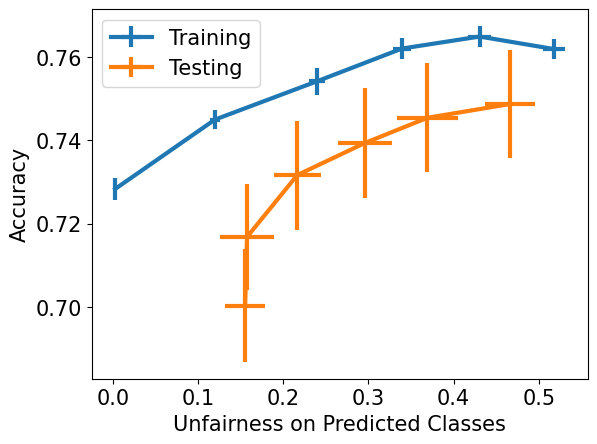

In [191]:
plt.errorbar(unfairness_mean, accuracy_mean, xerr=unfairness_error, yerr=accuracy_error, label = 'Training',linewidth=3.0)
plt.errorbar(unfairness_mean_test, accuracy_mean_test, xerr=unfairness_error_test, yerr=accuracy_error_test, label = 'Testing',linewidth=3.0)
plt.xlabel("Unfairness on Predicted Classes")
plt.ylabel("Accuracy")
plt.legend()
plt.rcParams.update({'font.size': 15})

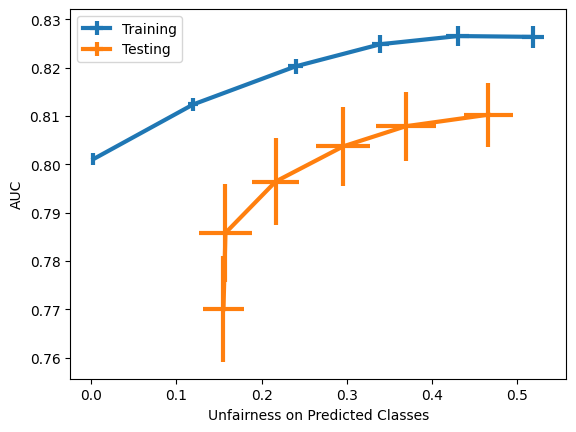

In [200]:
plt.errorbar(unfairness_mean, auc_mean, xerr=unfairness_error, yerr=auc_error, label = 'Training',linewidth=3.0)
plt.errorbar(unfairness_mean_test, auc_mean_test, xerr=unfairness_error_test, yerr=auc_error_test, label = 'Testing',linewidth=3.0)
plt.xlabel("Unfairness on Predicted Classes")
plt.ylabel("AUC")
plt.legend()
plt.rcParams.update({'font.size': 10})

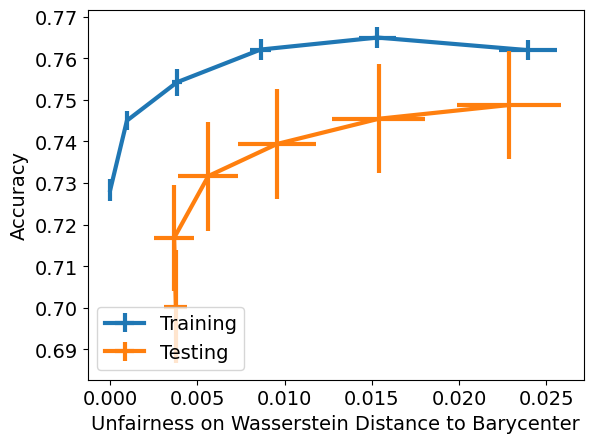

In [199]:
plt.errorbar(wasserstein_mean, accuracy_mean, xerr=wasserstein_error, yerr=accuracy_error, label = 'Training',linewidth=3.0)
plt.errorbar(wasserstein_mean_test, accuracy_mean_test, xerr=wasserstein_error_test, yerr=accuracy_error_test, label = 'Testing',linewidth=3.0)
plt.xlabel("Unfairness on Wasserstein Distance to Barycenter")
plt.ylabel("Accuracy")
plt.legend()
plt.rcParams.update({'font.size': 10})

In [201]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)

alpha = 0
temp_train = supports * 0
temp_test = supports_test * 0
for i in range(len(groupsize)):
    temp_train[tempsize[i] : tempsize[i + 1]] = (1 - alpha) * (
        train_proba_temp[i]
    ) + alpha * (supports[tempsize[i] : tempsize[i + 1]])
    temp_test[tempsize_test[i] : tempsize_test[i + 1]] = (1 - alpha) * (
        test_proba_temp[i]
    ) + alpha * (supports_test[tempsize_test[i] : tempsize_test[i + 1]])

temp_train = tsne.fit_transform(temp_train)
temp_test = tsne.fit_transform(temp_test)


In [202]:
import plotly.express as px

dftemp = pd.DataFrame(
    {"x": temp_train[:, 0], "y": temp_train[:, 1], "Income": train_data["Income"]}
)
fig1 = px.scatter(dftemp, x="x", y="y", color="Income")
fig1.update_traces(marker={"size": 3})
fig1.update_layout(
    title="t-SNE Training",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)
fig1.show()


dftemp = pd.DataFrame(
    {"x": temp_test[:, 0], "y": temp_test[:, 1], "Income": test_data["Income"]}
)
fig1 = px.scatter(dftemp, x="x", y="y", color="Income")
fig1.update_traces(marker={"size": 3})
fig1.update_layout(
    title="t-SNE Testing",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)
fig1.show()


In [203]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)

alpha = 1
temp_train = supports * 0
temp_test = supports_test * 0
for i in range(len(groupsize)):
    temp_train[tempsize[i] : tempsize[i + 1]] = (1 - alpha) * (
        train_proba_temp[i]
    ) + alpha * (supports[tempsize[i] : tempsize[i + 1]])
    temp_test[tempsize_test[i] : tempsize_test[i + 1]] = (1 - alpha) * (
        test_proba_temp[i]
    ) + alpha * (supports_test[tempsize_test[i] : tempsize_test[i + 1]])

temp_train = tsne.fit_transform(temp_train)
temp_test = tsne.fit_transform(temp_test)


In [204]:
import plotly.express as px

dftemp = pd.DataFrame(
    {"x": temp_train[:, 0], "y": temp_train[:, 1], "Income": train_data["Income"]}
)
fig1 = px.scatter(dftemp, x="x", y="y", color="Income")
fig1.update_traces(marker={"size": 3})
fig1.update_layout(
    title="t-SNE Training",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)
fig1.show()


dftemp = pd.DataFrame(
    {"x": temp_test[:, 0], "y": temp_test[:, 1], "Income": test_data["Income"]}
)
fig1 = px.scatter(dftemp, x="x", y="y", color="Income")
fig1.update_traces(marker={"size": 3})
fig1.update_layout(
    title="t-SNE Testing",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)
fig1.show()
